# Imports

In [101]:
# Para melhor organização dos dados em tabelas/matrizes
import pandas as pd

# Para separação de dados de treino e teste de forma consistente
from sklearn.model_selection import train_test_split

# Para as comparações
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn import tree as sktree

# Funções gerais
import math
from collections import Counter

# Import em download
import decision_tree_matott.tree as tree
#from decision_tree_matott.tree import ID3
#from decision_tree_matott.tree import C45
#from decision_tree_matott.tree import CART

# Import local
#import tree

# Preparação dos dados

## Base de dados

In [102]:
# Leitura e foramtação dos dados
dados = pd.read_csv('Data/titanic.csv', sep=';', na_values=["", " ", "NA", "N/A"])

In [103]:
dados = dados['PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked'].str.split(',', expand=True)
dados.columns = ['PassengerId', 'Survived', 'Pclass', 'Surname', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

In [104]:
dados_base = pd.DataFrame(dados)

In [105]:
dados_base

,PassengerId,Survived,Pclass,Surname,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"""Braund","Mr. Owen Harris""",male,22,1,0,A/5 21171,7.25,,S
1,2,1,1,"""Cumings","Mrs. John Bradley (Florence Briggs Thayer)""",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"""Heikkinen","Miss. Laina""",female,26,0,0,STON/O2. 3101282,7.925,,S
3,4,1,1,"""Futrelle","Mrs. Jacques Heath (Lily May Peel)""",female,35,1,0,113803,53.1,C123,S
4,5,0,3,"""Allen","Mr. William Henry""",male,35,0,0,373450,8.05,,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"""Montvila","Rev. Juozas""",male,27,0,0,211536,13,,S
887,888,1,1,"""Graham","Miss. Margaret Edith""",female,19,0,0,112053,30,B42,S
888,889,0,3,"""Johnston","Miss. Catherine Helen """"Carrie""""""",female,,1,2,W./C. 6607,23.45,,S
889,890,1,1,"""Behr","Mr. Karl Howell""",male,26,0,0,111369,30,C148,C


## Atributos irrelevantes

In [106]:
# PassengerId é condizente com a própria numeração na tabela e único a cada um
dados_base = dados_base.drop(columns=['PassengerId'])
# Nome é um atributo sempre único e sem impacto na sobrevivência do passageiro
dados_base = dados_base.drop(columns=['Surname', 'Name'])
# Ticket é provavelmente irrelevante (supondo que não reflete fatores como localização no navio e outros)
dados_base = dados_base.drop(columns=['Ticket'])
# Cabine pode ser relevante, mas tem uma taxa de 77% dos dados nulos, sendo então impreciso para a análise
dados_base = dados_base.drop(columns=['Cabin'])

## Tratamento de dados nulos

In [107]:
# Obter moda e inserir no lugar
for column in dados_base.columns:
    grupo = dados_base[column]

    # Determinar moda
    moda = Counter(grupo).most_common(1)[0][0]
    # Para evitar se moda for valor nulo
    if not moda:
        moda = Counter(grupo).most_common(2)[1][0]

    # Preencher dados vazios
    dados_base[column] = dados_base[column].fillna(moda)
    for linha in range(len(dados_base)):
        if ( type(dados_base[column][linha]) == str ):
            if not ( len(dados_base[column][linha]) > 0 ):
                dados_base.loc[linha, column] = ( moda )
        elif ( type(dados_base[column][linha]) == int ):
            if not ( dados_base[column][linha] >= 0 ):
                dados_base.loc[linha, column] = ( moda )
        elif ( dados_base[column][linha] == None ):
            dados_base.loc[linha, column] = ( moda )

## Dados numéricos

In [108]:
# Garantir que colunas de valor numérico estão salvas como valor float
colunas_numericas = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
for coluna in colunas_numericas:
    for instancia in range(len(dados_base[coluna])):
        dados_base.loc[instancia, coluna] = float(dados_base[coluna][instancia])

## Separação entre dados para cada algoritmo

In [109]:
# ID3
dados_id3 = dados_base.copy()
# C4.5
dados_c45 = dados_base.copy()
# CART
dados_cart = dados_base.copy()

## Tratamento de dados contínuos

In [110]:
colunas_continuas = ['Age', 'Fare']
n_intervalos = 10
# ID3
# Obter intervalo dos valores e determinar a qual parte do intervalo o valor pertence
for coluna in colunas_continuas:
    min = float(dados_id3[coluna][0])
    max = float(dados_id3[coluna][0])
    for instancia in range(len(dados_id3[coluna])):
        dados_id3.loc[instancia, coluna] = float(dados_id3[coluna][instancia])
        if dados_id3[coluna][instancia] < min:
            min = dados_id3[coluna][instancia]
        elif dados_id3[coluna][instancia] > max:
            max = dados_id3[coluna][instancia]
    interval_range = (max-min)/n_intervalos
    for instancia in range(len(dados_id3[coluna])):
        dados_id3.loc[instancia, coluna] = math.ceil(dados_id3[coluna][instancia]/interval_range)
# C4.5 e CART não precisam de tratamento de dados contínuos


# Partição treino/teste

In [111]:
# Separação de resultados
result_column = 'Survived'
# ID3
dados_id3_atributos  = dados_id3.drop(columns=[result_column])  # Atributos
dados_id3_resultados = dados_id3[result_column]                 # Conclusão
# C4.5
dados_c45_atributos  = dados_c45.drop(columns=[result_column])  # Atributos
dados_c45_resultados = dados_c45[result_column]                 # Conclusão
# CART
dados_cart_atributos  = dados_cart.drop(columns=[result_column])  # Atributos
dados_cart_resultados = dados_cart[result_column]                 # Conclusão

# Separar dados em treino e teste
test_sample = 0.20
# ID3
dados_id3_atributos_treino, dados_id3_atributos_teste, dados_id3_resultados_treino, dados_id3_resultados_teste = train_test_split(dados_id3_atributos, dados_id3_resultados, test_size = test_sample, random_state = 42)
# C4.5
dados_c45_atributos_treino, dados_c45_atributos_teste, dados_c45_resultados_treino, dados_c45_resultados_teste = train_test_split(dados_c45_atributos, dados_c45_resultados, test_size = test_sample, random_state = 42)
# CART
dados_cart_atributos_treino, dados_cart_atributos_teste, dados_cart_resultados_treino, dados_cart_resultados_teste = train_test_split(dados_cart_atributos, dados_cart_resultados, test_size = test_sample, random_state = 42)

# Montagem das árvores

# Restrições

In [112]:
altura_max = 6
min_informatio_gain = 0.150
min_gain_ratio      = 0.100
min_gini            = 0.265

# Montagem

In [113]:
# A chamada das classes muda se o import de classe for local (prefixo de 'tree.')
# ID3
tree_id3 = tree.ID3(max_height= altura_max, min_information= min_informatio_gain, results= dados_id3_resultados_treino)
tree_id3.create_tree(data= dados_id3_atributos_treino, result= dados_id3_resultados_treino)
# C4.5
tree_c45 = tree.C45(max_height= altura_max, min_information= min_gain_ratio, results= dados_c45_resultados_treino)
tree_c45.create_tree(data= dados_c45_atributos_treino, result= dados_c45_resultados_treino)
# CART
tree_cart = tree.CART(max_height= altura_max, min_information= min_gini, results= dados_cart_resultados_treino)
tree_cart.create_tree(data= dados_cart_atributos_treino, result= dados_cart_resultados_treino)

# Resultados

## ID3

### Árvore

In [114]:
print(tree_id3.__str__())

0 - 0 (/'1' 268//'0' 444/) | Informacao: 0.21537571560753244 | Regra derivada: Sex
  {Sex==male}  1 - 0 (/'1' 87//'0' 380/) | Informacao: 0.05532234115131962 | Regra derivada: (Final)
  {Sex==female}  1 - 1 (/'1' 181//'0' 64/) | Informacao: 0.23487005404128802 | Regra derivada: Pclass
    {Pclass==1.0}  2 - 1 (/'1' 67//'0' 3/) | Informacao: 0.11887399721063424 | Regra derivada: (Final)
    {Pclass==2.0}  2 - 1 (/'1' 58//'0' 2/) | Informacao: 0.04531556019707861 | Regra derivada: (Final)
    {Pclass==3.0}  2 - 0 (/'1' 56//'0' 59/) | Informacao: 0.0845875396222503 | Regra derivada: (Final)


### Teste

In [115]:
confusionMatrix_ID3 = tree_id3.test_tree(test_data= dados_id3_atributos_teste, test_results= dados_id3_resultados_teste)

In [116]:
len(dados_id3_atributos_teste)

179

In [117]:
confusionMatrix_ID3

,1,0
1,36,38
0,4,101


In [118]:
medidas_ID3 = tree.result_metrics(confusionMatrix_ID3)
medidas_ID3

,VP,FN,VN,FP,Precision,Recall,F1-Score,Accuracy
1,36,38,101,4,0.9,0.486486,0.631579,0.765363
0,101,4,36,38,0.726619,0.961905,0.827869,0.765363


## C4.5

### Árvore

In [119]:
print(tree_c45.__str__())

0 - 0 (/1 268//0 444/) | Razão de ganho: 0.1159568277286427 | Regra derivada: Sex
  {Sex==male}  1 - 0 (/1 87//0 380/) | Razão de ganho: 0.04263681792815832 | Regra derivada: (Final)
  {Sex==female}  1 - 1 (/1 181//0 64/) | Razão de ganho: 0.2346347328409777 | Regra derivada: Pclass
    {Pclass>2.0}  2 - 0 (/1 56//0 59/) | Razão de ganho: 0.14884830480180877 | Regra derivada: Fare
      {Fare>23.25}  3 - 0 (/1 1//0 20/) | Razão de ganho: 0.14501030849729774 | Regra derivada: Age
        {Age>5.0}  4 - 0 (/0 18/) | Razão de ganho: 1.0 | Regra derivada: (Final)
        {Age<=5.0}  4 - 0 (/1 1//0 2/) | Razão de ganho: 0.9182958340544896 | Regra derivada: Age
          {Age>2.0}  5 - 1 (/1 1/) | Razão de ganho: 1.0 | Regra derivada: (Final)
          {Age<=2.0}  5 - 0 (/0 2/) | Razão de ganho: 1.0 | Regra derivada: (Final)
      {Fare<=23.25}  3 - 1 (/1 55//0 39/) | Razão de ganho: 0.03628540704306005 | Regra derivada: (Final)
    {Pclass<=2.0}  2 - 1 (/1 125//0 5/) | Razão de ganho: 0.022

### Teste

In [120]:
confusionMatrix_C45 = tree_c45.test_tree(test_data= dados_c45_atributos_teste, test_results= dados_c45_resultados_teste)

In [121]:
len(dados_c45_atributos_teste)

179

In [122]:
confusionMatrix_C45

,1,0
1,50,24
0,13,92


In [123]:
medidas_C45 = tree.result_metrics(confusionMatrix_C45)
medidas_C45

,VP,FN,VN,FP,Precision,Recall,F1-Score,Accuracy
1,50,24,92,13,0.793651,0.675676,0.729927,0.793296
0,92,13,50,24,0.793103,0.87619,0.832579,0.793296


## CART

### Árvore

In [124]:
print(tree_cart.__str__())

{}  0 - 0 (/1 268//0 444/) | Gini: 0.331668325487691 | Regra derivada: Sex
  {Sex==male}  1 - 0 (/1 87//0 380/) | Gini: 0.2789005955909212 | Regra derivada: Age
    {Age>6.0}  2 - 0 (/1 72//0 373/) | Gini: 0.256749839381719 | Regra derivada: (Final)
    {Age<=6.0}  2 - 1 (/1 15//0 7/) | Gini: 0.07954545454545454 | Regra derivada: (Final)
  {Sex!=male}  1 - 1 (/1 181//0 64/) | Gini: 0.2737806293085796 | Regra derivada: Pclass
    {Pclass>2.0}  2 - 0 (/1 56//0 59/) | Gini: 0.41341791110523773 | Regra derivada: Fare
      {Fare>23.25}  3 - 0 (/1 1//0 20/) | Gini: 0.06349206349206349 | Regra derivada: (Final)
      {Fare<=23.25}  3 - 1 (/1 55//0 39/) | Gini: 0.4604870306997967 | Regra derivada: Embarked
        {Embarked==S}  4 - 0 (/1 27//0 28/) | Gini: 0.4591800356506238 | Regra derivada: Fare
          {Fare>7.65}  5 - 0 (/1 23//0 28/) | Gini: 0.44305120167189127 | Regra derivada: Fare
            {Fare>10.5167}  6 - 1 (/1 14//0 8/) | Gini: 0.38474025974025977 | Regra derivada: (Final)


### Teste

In [125]:
confusionMatrix_CART = tree_cart.test_tree(test_data= dados_cart_atributos_teste, test_results= dados_cart_resultados_teste)

In [126]:
len(dados_cart_atributos_teste)

179

In [127]:
confusionMatrix_CART

,1,0
1,48,26
0,10,95


In [128]:
medidas_CART = tree.result_metrics(confusionMatrix_CART)
medidas_CART

,VP,FN,VN,FP,Precision,Recall,F1-Score,Accuracy
1,48,26,95,10,0.827586,0.648649,0.727273,0.798883
0,95,10,48,26,0.785124,0.904762,0.840708,0.798883


## Comparação

### Pré-processamento

In [129]:
#
cols_label_encode = ['Sex']
dados_cart_atributos_treino[cols_label_encode] = dados_cart_atributos_treino[cols_label_encode].apply(LabelEncoder().fit_transform)
dados_cart_atributos_teste[cols_label_encode] = dados_cart_atributos_teste[cols_label_encode].apply(LabelEncoder().fit_transform)

#
for i in dados_cart_atributos_treino.index:
    if   dados_cart_atributos_treino['Embarked'][i] == "C":
        dados_cart_atributos_treino.loc[i, 'Embarked'] = 0
    elif dados_cart_atributos_treino['Embarked'][i] == "Q":
        dados_cart_atributos_treino.loc[i, 'Embarked'] = 1
    elif dados_cart_atributos_treino['Embarked'][i] == "S":
        dados_cart_atributos_treino.loc[i, 'Embarked'] = 2
for i in dados_cart_atributos_teste.index:
    if   dados_cart_atributos_teste['Embarked'][i] == "C":
        dados_cart_atributos_teste.loc[i, 'Embarked'] = 0
    elif dados_cart_atributos_teste['Embarked'][i] == "Q":
        dados_cart_atributos_teste.loc[i, 'Embarked'] = 1
    elif dados_cart_atributos_teste['Embarked'][i] == "S":
        dados_cart_atributos_teste.loc[i, 'Embarked'] = 2


### Criação e resultado da árvore

c:\Linguagens\Python\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


0.8044692737430168

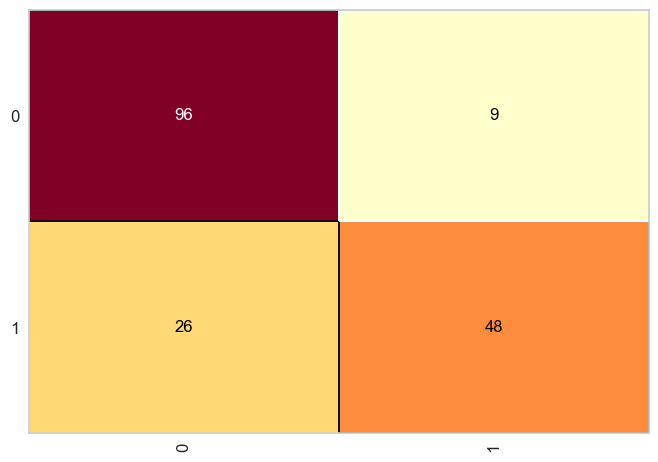

In [130]:
# Comparação da árvore de CART gerada com a da biblioteca sklearn
arvore_comparacao = DecisionTreeClassifier(criterion='gini', max_depth= altura_max)
arvore_comparacao.fit(dados_cart_atributos_treino, dados_cart_resultados_treino)
cm_comparacao = ConfusionMatrix(arvore_comparacao)
cm_comparacao.fit(dados_cart_atributos_treino, dados_cart_resultados_treino)
cm_comparacao.score(dados_cart_atributos_teste, dados_cart_resultados_teste)

In [131]:
previsoes = arvore_comparacao.predict(dados_cart_atributos_teste)
print(classification_report(dados_cart_resultados_teste, previsoes))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       105
           1       0.84      0.65      0.73        74

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.80      0.80       179



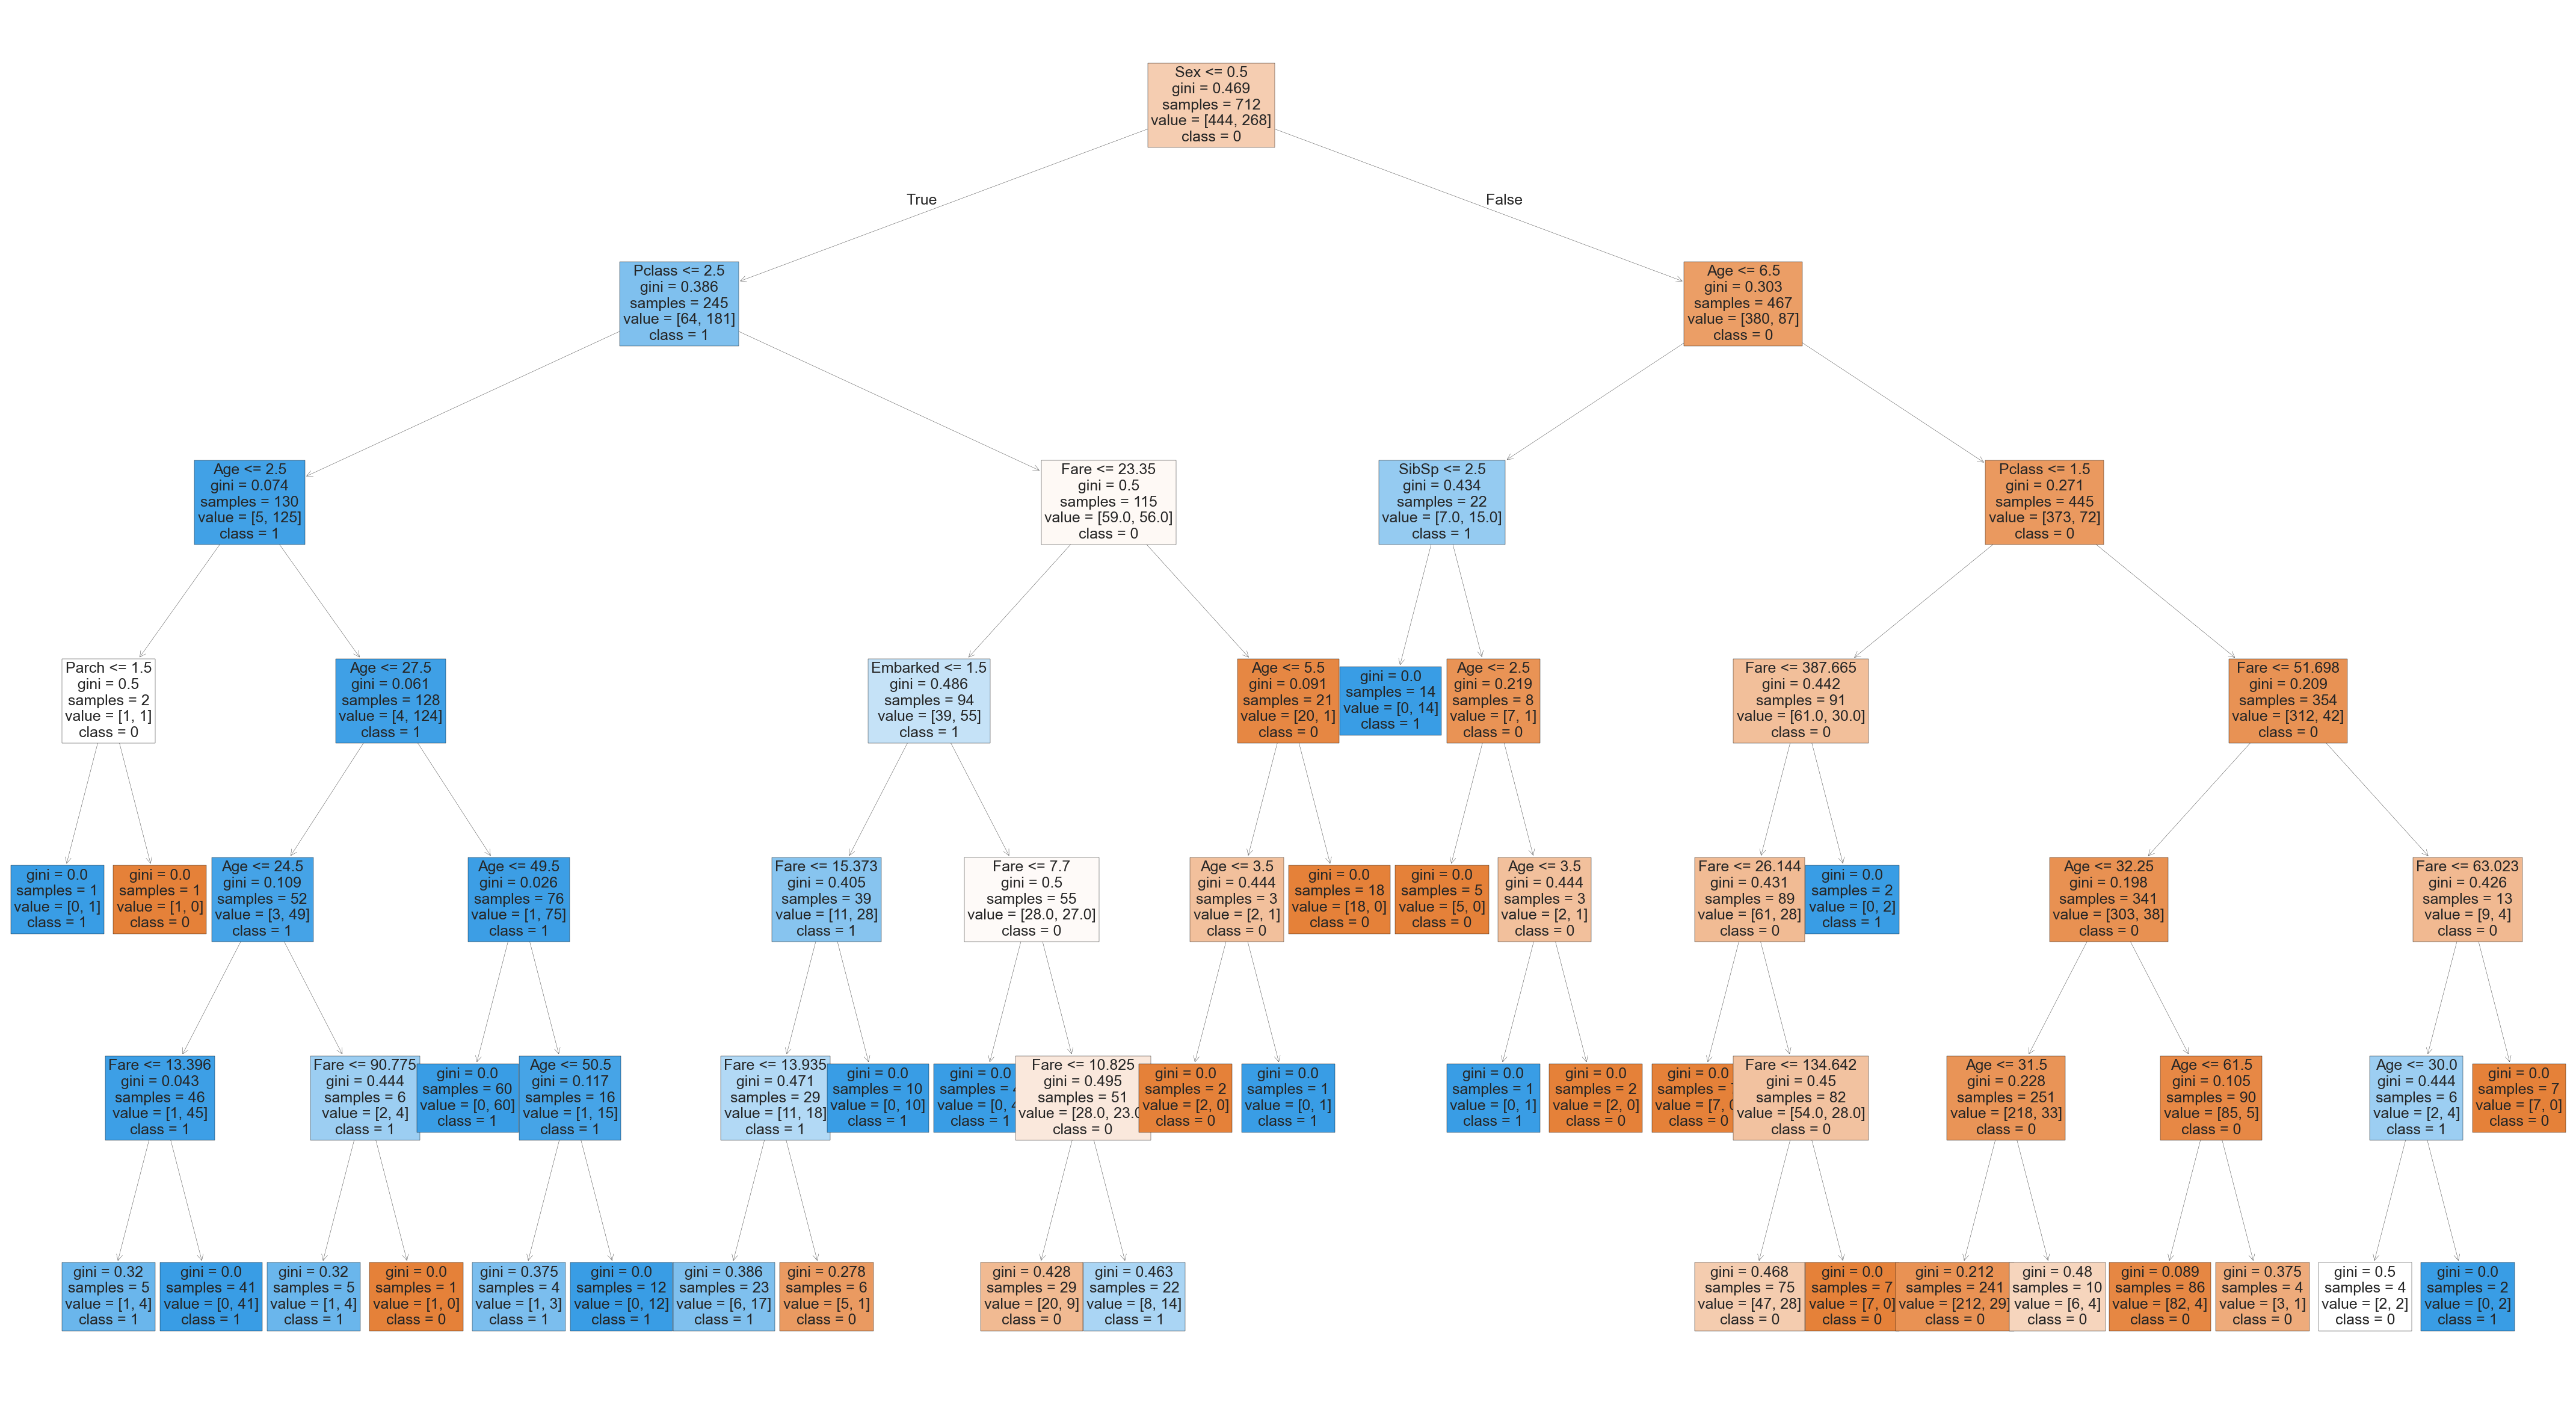

In [134]:
previsores = dados_cart_atributos_treino.columns
figura, eixos = plt.subplots(nrows=1, ncols=1, figsize=(55,30))
sktree.plot_tree(arvore_comparacao, feature_names=previsores, class_names = arvore_comparacao.classes_, filled=True, fontsize=18);